In [18]:
from tmm import *
import itertools 
import math
import numpy as np
import pandas as pd
import os
#from tqdm import tqdm
from p_tqdm import p_map
from scipy.spatial.distance import squareform, pdist
import keras

def convert(number:float,type_str:str,convert_str:str,length_unit_in_meter=150e-9,n=1):
    #
    # Utility function for unit conversion
    #
    from math import pi
    k = None # frequency
    l = None # wavelength
    c = 3e8 / n
    a = length_unit_in_meter 
    units_f = {"THz" : 1e-12 * c / a, "Hz" : c / a, "c/a" : 1, "/m" : 2 * pi / a, "/cm" : 2 * pi / a / 100, "/nm" :  2 * pi / a / 1e9, "/a": 2 * pi}
    units_l = {"m" : a, "nm" : 1e9 * a, "a" : 1}
    units = {**units_f, **units_l}
    if (type_str not in units) or (convert_str not in units) : 
        raise NotImplementedError("Unit is not recognized")
    elif (type_str in units_f) == (convert_str in units_f):
        return units[convert_str] / units[type_str] * number
    else :
        return units[convert_str] * units[type_str] / number

def generate_structure(count,layers=16,n1=1.4,n2=2.1,d_min=10e-9,d_max=150e-9):
    #
    # Define uniform search parameter space, No material dispersion
    #
    resolution = math.ceil(count ** (1/layers))
    space_size = resolution ** layers 
    ignore_below = 1e-12
    _digits = -math.floor(math.log(ignore_below,10))
    d = [round(x,_digits) for x in np.linspace(d_min,d_max,resolution)]
    d_lists = itertools.product(*([d]*layers))
    n_list = [1.0] + ([n1,n1]*((layers+1)//2))[:layers] + [1.0]
    for i, d in enumerate(d_lists):
        if i == count : break
        yield {"d" : [np.inf, *d, np.inf],
               "n": n_list}

def get_parameter_count(config:dict):
    return config["layer_count"]
def get_parameter_names(config:dict):
    return ['param_'+str(i) for i in range(get_parameter_count(config))]
def get_parameter(structure:dict):
    return structure["d"][1:-1]
    
def calculate_spectrum(structure:dict, ks:list=np.linspace(0.0104720, 0.00628319, num=200)):
    n_list = structure["n"]
    d_list = [x*1e9 for x in structure["d"]]
    spectrum = [coh_tmm('s', n_list, d_list, 0, 1/k)['R'] for k in ks]
    return spectrum
    
def calculate_spectrum_all(config):
    #
    # Precalculate spectrum (forward looking!)
    # row = structure
    # column = wavelength
    #
    filename = f"pkl/sim_{hash(str(config))}.pkl"
    if os.path.isfile(filename):
        df = pd.read_pickle(filename)
    else :
        structures = generate_structure(config["simulation_count"],layers=config["layer_count"])
        f1 = convert(config["spectral_range"][1], "c/a", "/nm")
        f2 = convert(config["spectral_range"][0], "c/a", "/nm")
        ks = np.linspace(f1, f2, config["spectral_resolution"])
        # results = [ get_parameter(s) + calculate_spectrum(s, ks) for s in tqdm(structures, total = config["simulation_count"])]
        results = p_map(lambda x : get_parameter(x) + calculate_spectrum(x,ks), list(structures))
        columns = get_parameter_names(config) + list(ks)
        df = pd.DataFrame(results, columns = columns)
        df.to_pickle(filename)
    return df

def filter_similar_spectrum(config, df, thres_ratio=0.1, plot=False):
    #
    # Filter spectrum by euclidian distance
    # However it is still overdetermined 
    # 
    assert(0<=thres_ratio<=1)
    assert(df.shape== (config["simulation_count"], get_parameter_count(config) + config["spectral_resolution"]))
    distance = pdist(df.iloc[:,get_parameter_count(config):])
    dist_mat = pd.DataFrame(np.triu(squareform(distance)))
    maxcorr = dist_mat.max()
    thres = np.quantile(maxcorr, thres_ratio)
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.matshow(dist_mat, cmap = 'Greys', vmin=0, vmax=1)
        # plt.figure()
        # plt.hist(distance,bins=50)
        # plt.figure()
        # maxcorr.hist(bins=50)
        plt.figure()
        plt.matshow(dist_mat.loc[maxcorr<thres,maxcorr<thres], cmap = 'Greys', vmin=0, vmax=1)
    return df[maxcorr<thres]

def train_test_split(df,ratio):
    train_count = math.floor(df.shape[0] * ratio)
    df.reindex(np.random.permutation(df.index))
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:train_count,:]
    df_train.reset_index(inplace=True, drop=True)
    df_test = df.iloc[train_count:,:]
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [40]:
config = {
    "simulation_count" : 100,
    "layer_count" : 4,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200
}
df = calculate_spectrum_all(config)

df = df[:]
df = filter_similar_spectrum(config, thres_ratio = 0.1, plot=False)

100

In [3]:
# define model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf

model_forward = Sequential([
  keras.Input(shape=(get_parameter_count(config))),
  Dense(config["spectral_resolution"], activation='relu'),
  Dense(config["spectral_resolution"]*2.5, activation='relu'),
  Dense(config["spectral_resolution"]),
])
model_forward.summary()
model_forward.compile(optimizer='adam',
                loss=tf.keras.losses.mae,
                metrics=['accuracy'])

model_backward = Sequential([
  keras.Input(shape=(config["spectral_resolution"])),
  Dense(config["spectral_resolution"]*2.5, activation='relu'),
  Dense(config["spectral_resolution"], activation='relu'),
  Dense(get_parameter_count(config), activation='relu'),
] + model_forward.layers)
model_backward.summary()
model_backward.compile(optimizer='adam',
                loss=tf.keras.losses.mae,
                metrics=['accuracy'])

model_inverse = Sequential([
  keras.Input(shape=(config["spectral_resolution"])) ] 
    + model_backward.layers[:-len(model_forward.layers)])
model_inverse.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
Total params: 201,700
Trainable params: 201,700
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               100200    
____________________________

Epoch 1/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.0500
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.1100
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.0400
Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.0200
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.0400
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.0500
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0054 - accuracy: 0.0200
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.0100
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 0.1000


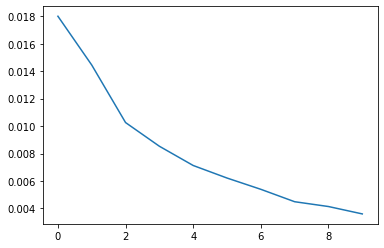

Epoch 1/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.2500
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0126 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0100 - accuracy: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0093 - accuracy: 0.0100
Epoch 9/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0085 - accuracy: 0.0600
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0072 - accuracy: 0.0000e+00


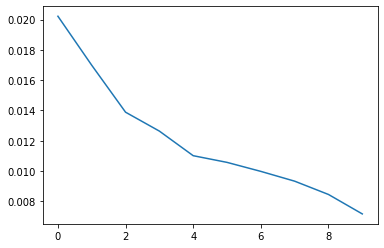

In [49]:
# Prepare data 
X = df.iloc[:,:get_parameter_count(config)]
Y = df.iloc[:,get_parameter_count(config):]
normalizer = Normalization()
normalizer.adapt(X.values)

import matplotlib.pyplot as plt
train_ecochs = 10

# forward train
history_forward = model_forward.fit(x=normalizer(X), y=Y.values, epochs=train_ecochs)
plt.plot(history_forward.history['loss'])
#plt.plot(history_forward.history['val_loss'])
plt.show()

# backward train
# freeze forward layers
for l in model_forward.layers:
    l.trainable=False
history_backward = model_backward.fit(x=Y.values, y=Y.values, epochs=train_ecochs)
plt.plot(history_backward.history['loss'])
#plt.plot(history_backward.history['val_loss'])
plt.show()

In [5]:
# Inverse design

def denormalize(normalizer, tensor):
    output = []
    for x,y,z in zip(
        np.array(normalizer.mean),
        np.array(normalizer.variance),
        np.array(tensor[0])
    ):
        output.append(x+math.sqrt(y)*z)
    return output

test_input = tf.reshape(tf.convert_to_tensor(Y.iloc[0,:].values),(1,config["spectral_resolution"]))
test_output = denormalize(normalizer, model_inverse(test_input))
print(test_output)


[2.4482861959995716e-08, 4.540234499472717e-08, 5.0909194524332616e-08, 4.701155020825354e-08]


In [7]:
## tests

def __test_structure():
#     return [
#         [ round(y*1e9) for y in x["d"] if np.isfinite(y)]
#         for x in generate_structure(100,layers=4)
#     ]
    return [ x for x in generate_structure(100,layers=4) ]
        
def __test_tmm():
    f1 = 0.15
    f2 = 0.25
    ks = np.linspace(convert(f2, "c/a", "/nm"), convert(f1, "c/a", "/nm"),200)
    structure = {
        'd': [inf, 1e-08, 5.6667e-08, 1e-08, 5.6667e-08, inf],
        'n': [1.0, 1.4, 1.4, 1.4, 1.4, 1.0]
    }
    import matplotlib.pyplot as plt
    Rnorm = calculate_spectrum(structure, ks)
    plt.plot(ks * 1e7, Rnorm, 'blue')
    return Rnorm
        
def __test_multiple_tmm():
    f1 = 0.15
    f2 = 0.25
    ks = np.linspace(convert(f2, "c/a", "/nm"), convert(f1, "c/a", "/nm"),200)
    a = generate_structure(100,layers=4)
    import matplotlib.pyplot as plt
    [next(a) for x in range(50)]
    Rnorm = calculate_spectrum(next(a), ks)
    plt.plot(ks * 1e7, Rnorm, 'blue')
    plt.xlabel('k (cm$^{-1}$)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light at 0$^\circ$ incidence')
    return Rnorm

def __test_simulation():
    config = {
        "simulation_count" : 100,
        "layer_count" : 4,
        "spectral_range" : (0.15,0.25),
        "spectral_resolution" : 200
    }
    df = calculate_spectrum_all(config)
    return df

#__test_structure()
#__test_tmm()
#__test_multiple_tmm()
#__test_simulation()